In [1]:
#10core

import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import random
from numpy import mean
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
import scipy.stats as sps
from sklearn.metrics import make_scorer, average_precision_score, f1_score

In [2]:
random.seed(10)

data = pd.read_csv("training_data_v10_imbalanced_v2.csv", sep=",")

print(data.shape)

(212, 81)


In [3]:
data

,symbol,locus,DIST_MEAN,DIST_MIN,DIST_MEAN_NBH,DIST_MIN_NBH,TSS_MEAN,TSS_MIN,TSS_MEAN_NBH,TSS_MIN_NBH,...,CALB1_CALCR_MEAN_expression_NBH,CALB1_CRYM_CCDC68_MEAN_expression_NBH,CALB1_GEM_MEAN_expression_NBH,CALB1_PPP1R17_MEAN_expression_NBH,CALB1_RBP4_MEAN_expression_NBH,CALB1_TRHR_MEAN_expression_NBH,SOX6_AGTR1_MEAN_expression_NBH,SOX6_DDT_MEAN_expression_NBH,SOX6_GFRA2_MEAN_expression_NBH,label
0,ABCD2,49,584824,385596,-1.861036,-12.862548,584773,385545,-1.440449,-2.943055,...,0.025694,0.021705,0.017977,0.025972,0.023470,0.023125,0.036248,0.038911,0.029120,0
1,ACBD4,68,520404,148933,-0.040912,-11.911259,527022,160515,-0.035732,-3.540022,...,0.019120,0.019887,0.015687,0.020768,0.029031,0.017874,0.014322,0.019944,0.017692,0
2,ACBD4,69,720973,148933,-0.986702,-11.911259,732555,160515,-0.714254,-2.674878,...,0.011756,0.012101,0.010331,0.012749,0.013454,0.009644,0.009494,0.010370,0.010835,0
3,ADAM11,68,567351,401769,-0.127284,-12.903635,580395,401725,-0.132198,-4.457399,...,0.044261,0.047463,0.026579,0.062088,0.061221,0.051176,0.024962,0.039510,0.055562,0
4,ADAM11,69,1083307,511267,-1.393874,-13.144649,1106166,534126,-1.126371,-3.877118,...,0.027213,0.028880,0.017503,0.038114,0.028372,0.027611,0.016547,0.020543,0.034027,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,ZBTB7B,1,307799,76942,-0.301153,-11.250820,321039,76920,-0.330456,-5.395462,...,0.008755,0.015636,0.013066,0.012546,0.012718,0.010557,0.015374,0.019185,0.009423,0
208,ZNF141,19,572710,546723,-4.751600,-13.211699,619761,593774,-3.193878,-6.628572,...,0.148045,0.141816,0.165724,0.158377,0.114330,0.155191,0.128384,0.121508,0.157051,0
209,ZNF595,19,863264,837277,-5.161940,-13.637911,-10,-10,-10.000000,-10.000000,...,0.103599,0.094918,0.111148,0.116129,0.071070,0.102368,0.103433,0.079435,0.090195,0
210,ZNF721,19,458418,432431,-4.529002,-12.977180,458419,432432,-2.892328,-6.311499,...,1.000000,1.000000,1.000000,1.000000,0.619930,1.000000,1.000000,0.784500,1.000000,0


In [4]:
data.describe()

,locus,DIST_MEAN,DIST_MIN,DIST_MEAN_NBH,DIST_MIN_NBH,TSS_MEAN,TSS_MIN,TSS_MEAN_NBH,TSS_MIN_NBH,VEP_IMPACT_MAX,...,CALB1_CALCR_MEAN_expression_NBH,CALB1_CRYM_CCDC68_MEAN_expression_NBH,CALB1_GEM_MEAN_expression_NBH,CALB1_PPP1R17_MEAN_expression_NBH,CALB1_RBP4_MEAN_expression_NBH,CALB1_TRHR_MEAN_expression_NBH,SOX6_AGTR1_MEAN_expression_NBH,SOX6_DDT_MEAN_expression_NBH,SOX6_GFRA2_MEAN_expression_NBH,label
count,212.000000,2.120000e+02,212.000000,212.000000,212.000000,2.120000e+02,2.120000e+02,212.000000,212.000000,23.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,35.433962,5.674541e+05,288994.584906,-1.423060,-10.681379,5.816479e+05,3.040884e+05,-1.059333,-4.193918,0.183043,...,0.104633,0.117649,0.105995,0.124675,0.133097,0.113307,0.105360,0.125087,0.112466,0.037736
std,29.865899,3.264860e+05,275609.951668,1.431821,4.042804,3.251031e+05,2.702420e+05,1.261296,2.166190,0.194829,...,0.215906,0.224284,0.213124,0.225677,0.226778,0.217503,0.219435,0.226903,0.218411,0.191008
min,1.000000,4.946000e+03,0.000000,-5.227535,-13.794301,-1.000000e+01,-1.000000e+01,-10.000000,-10.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.980490e+05,47563.250000,-1.752407,-12.956542,3.299038e+05,7.129500e+04,-1.439187,-5.814361,0.100000,...,0.003153,0.003473,0.004269,0.004327,0.004929,0.004436,0.002604,0.003380,0.003336,0.000000
50%,23.000000,5.288170e+05,186407.500000,-1.135429,-12.097987,5.512295e+05,2.467635e+05,-0.831497,-4.014605,0.100000,...,0.024064,0.029336,0.027146,0.036605,0.035212,0.030929,0.024782,0.034853,0.029796,0.000000
75%,69.000000,7.726870e+05,434503.250000,-0.257468,-10.624594,7.802705e+05,4.422610e+05,-0.157921,-2.795158,0.100000,...,0.094783,0.105204,0.093152,0.117625,0.144055,0.102095,0.089032,0.120088,0.102900,0.000000
max,70.000000,1.351332e+06,979013.000000,0.000000,0.000000,1.351311e+06,1.093542e+06,0.000000,0.000000,0.660000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
X, y = data.iloc[:,2:-1],data.iloc[:,-1]


In [6]:
imbalance = round(len(y)/sum(y))

In [7]:
#naive XGBoost
model = xgb.XGBClassifier(objective="binary:logistic", random_state=123)
cv = StratifiedKFold(n_splits=5)

# evaluate model
ap_scores = cross_val_score(model, X, y, scoring='average_precision', cv=cv, n_jobs=1)
f1_scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=1)

# summarize performance
print('Mean Average Precision: %.5f' % mean(ap_scores))
print('Mean F1: %.5f' % mean(f1_scores))


Mean Average Precision: 0.69667
Mean F1: 0.33333


In [8]:
classifiers = {
    ('xgboost', 'xgboost'):
        xgb.XGBClassifier(
            booster="gbtree", # gbtree|dart
            objective="binary:logistic",
            random_state=123,
            n_jobs=1
        )
}

In [9]:
param_grid = {
    'xgboost': {
        'n_estimators': sps.randint(100, 1000), # Same as nrounds
        'eta': sps.uniform(0, 0.4),
        'min_child_weight': sps.uniform(0, 10),
        'gamma': sps.expon(0, 0.1),
        'subsample': sps.uniform(0.4, 0.6), # [0.4, 1]
        'colsample_bytree': sps.uniform(0.4, 0.6), # [0.4, 1]
        'colsample_bylevel': sps.uniform(0.4, 0.6), # [0.4, 1]
        'max_depth': sps.randint(10, 50), # 100 is too high
        'learning_rate': sps.expon(0, 0.01),
        'reg_lambda': sps.uniform(0, 100),
        'max_delta_step': [1], # Usually this parameter is not needed (0), but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update
        'scale_pos_weight': [imbalance]
    }
}

In [10]:
cv_scorer = make_scorer(average_precision_score, needs_proba=True)
grid_search = RandomizedSearchCV(
    estimator=classifiers[('xgboost', 'xgboost')],
    param_distributions=param_grid["xgboost"],
    scoring=cv_scorer,
    n_jobs=10,
    cv=5,
    verbose=1,
    n_iter=500
)

In [11]:
grid_search.fit(
    X,
    y,
    verbose=0
)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=N...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b53cf449580>,
      

In [12]:
model = grid_search.best_estimator_

# evaluate model
ap_scores = cross_val_score(model, X, y, scoring='average_precision', cv=5, n_jobs=1)
f1_scores = cross_val_score(model, X, y, scoring='f1', cv=5, n_jobs=1)

# summarize performance
print('Mean Average Precision: %.5f' % mean(ap_scores))
print('Mean F1: %.5f' % mean(f1_scores))

Mean Average Precision: 0.81667
Mean F1: 0.37333


In [19]:
ap_scores

array([0.58333333, 0.83333333, 1.        , 1.        , 0.66666667])

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve

def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    """
    Draw a Cross Validated PR Curve.
    Keyword Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        X: Feature Pandas DataFrame
        y: Response Pandas Series
        
    Largely taken from: https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
    """
    y_real = []
    y_proba = []

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        precision, recall, _ = precision_recall_curve(y.iloc[test], probas_[:, 1])
        
        # Plotting each individual PR Curve
        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y.iloc[test], probas_[:, 1])))
        
        y_real.append(y.iloc[test])
        y_proba.append(probas_[:, 1])

        i += 1
    
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    plt.plot(recall, precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (average_precision_score(y_real, y_proba)),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

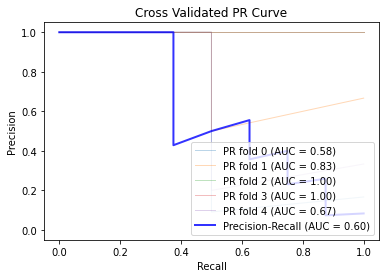

In [18]:
FOLDS = 5

# Set up Stratified K Fold
cv = StratifiedKFold(n_splits=5)

draw_cv_pr_curve(model, cv, X, y, title='Cross Validated PR Curve')

In [13]:
joblib.dump(grid_search, "XGBoost.model.joblib.imbalanced.v2.gz", compress=True)

['XGBoost.model.joblib.imbalanced.v2.gz']

In [14]:
xg_reg = model

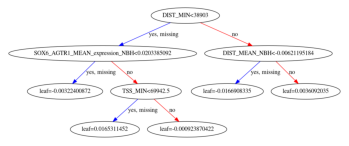

In [15]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

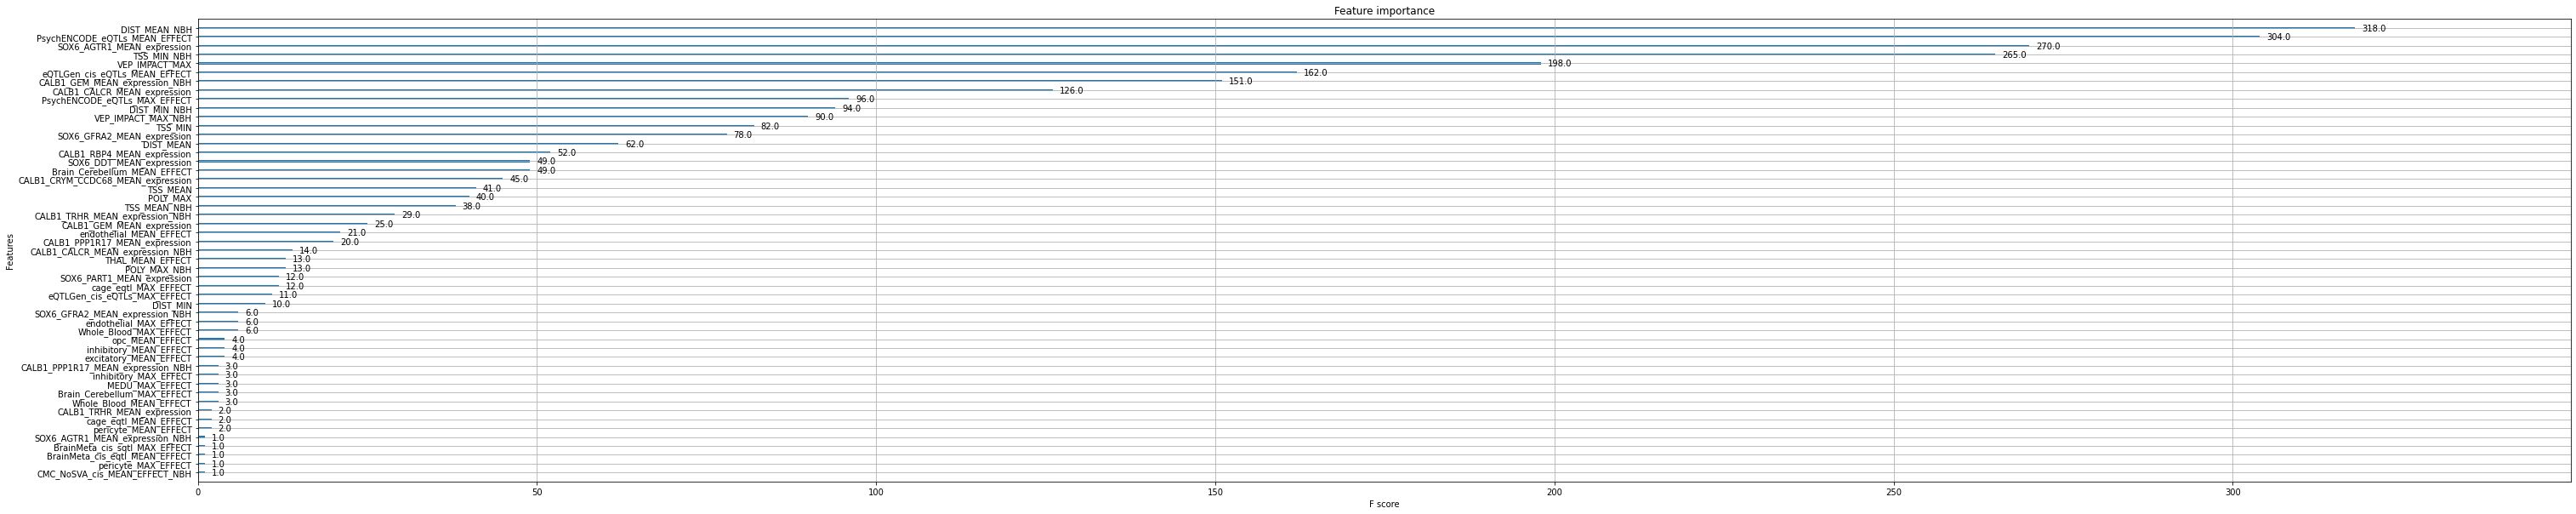

In [16]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.savefig('xgb_fea_imp_imbalanced.pdf')

In [17]:
xgb_fea_imp=pd.DataFrame(list(xg_reg.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)
xgb_fea_imp.to_csv('xgb_fea_imp_imbalanced.csv')

                               feature  importance
2                       DIST_MEAN_NBH       318.0
14      PsychENCODE_eQTLs_MEAN_EFFECT       304.0
41         SOX6_AGTR1_MEAN_expression       270.0
7                         TSS_MIN_NBH       265.0
8                      VEP_IMPACT_MAX       198.0
13      eQTLGen_cis_eQTLs_MEAN_EFFECT       162.0
46      CALB1_GEM_MEAN_expression_NBH       151.0
35        CALB1_CALCR_MEAN_expression       126.0
20       PsychENCODE_eQTLs_MAX_EFFECT        96.0
3                        DIST_MIN_NBH        94.0
10                 VEP_IMPACT_MAX_NBH        90.0
5                             TSS_MIN        82.0
43         SOX6_GFRA2_MEAN_expression        78.0
0                           DIST_MEAN        62.0
39         CALB1_RBP4_MEAN_expression        52.0
12       Brain_Cerebellum_MEAN_EFFECT        49.0
42           SOX6_DDT_MEAN_expression        49.0
36  CALB1_CRYM_CCDC68_MEAN_expression        45.0
4                            TSS_MEAN        41.0

In [18]:
X_data_df = pd.read_csv("testing_data_v10_imbalanced_v2.csv", sep=",")
X_data = X_data_df.iloc[:,2:]

In [19]:
X_data

,DIST_MEAN,DIST_MIN,DIST_MEAN_NBH,DIST_MIN_NBH,TSS_MEAN,TSS_MIN,TSS_MEAN_NBH,TSS_MIN_NBH,VEP_IMPACT_MAX,POLY_MAX,...,SOX6_PART1_MEAN_expression,CALB1_CALCR_MEAN_expression_NBH,CALB1_CRYM_CCDC68_MEAN_expression_NBH,CALB1_GEM_MEAN_expression_NBH,CALB1_PPP1R17_MEAN_expression_NBH,CALB1_RBP4_MEAN_expression_NBH,CALB1_TRHR_MEAN_expression_NBH,SOX6_AGTR1_MEAN_expression_NBH,SOX6_DDT_MEAN_expression_NBH,SOX6_GFRA2_MEAN_expression_NBH
0,420802,408328,-12.949920,-12.919829,420838,408363,-3.904186,-4.578742,NaN,NaN,...,0.001134,0.000224,0.000178,0.000224,0.000000,0.000233,0.000325,0.000157,0.000308,0.000196
1,340682,328207,-12.738708,-12.701403,340680,328206,-3.692882,-4.360228,NaN,NaN,...,0.000378,0.000090,0.000000,0.000112,0.000175,0.000000,0.000000,0.000063,0.000077,0.000000
2,405153,379150,-12.912023,-12.845690,436629,410626,-2.331042,-2.650320,NaN,NaN,...,0.407785,0.068435,0.082249,0.057140,0.071683,0.066419,0.083333,0.048505,0.054674,0.066296
3,359367,314779,-4.131328,-12.659629,373338,328750,-3.153969,-5.235685,NaN,NaN,...,0.300076,0.024679,0.028869,0.023080,0.031114,0.022607,0.023174,0.030686,0.025195,0.029113
4,661597,650303,-3.914366,-4.729284,769982,758688,-4.025475,-4.792472,NaN,NaN,...,0.021542,0.006177,0.058012,0.072935,0.018771,0.022414,0.000845,0.001096,0.001877,0.003022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,353537,353537,-2.271857,-2.271857,336665,336665,-2.210717,-2.210717,NaN,NaN,...,0.018896,0.034163,0.039334,0.019178,0.037479,0.073171,0.051903,0.027368,0.043122,0.035714
1698,660906,660906,-2.897480,-2.897480,672477,672477,-2.902595,-2.902595,NaN,NaN,...,0.514361,0.780381,0.789713,0.530594,0.826235,0.864745,0.861592,0.682184,0.621179,0.755357
1699,553669,553669,-2.720435,-2.720435,585246,585246,-2.763660,-2.763660,NaN,NaN,...,0.907785,0.546120,0.508321,1.000000,0.390119,0.773836,0.391003,1.000000,1.000000,0.985714
1700,453863,453863,-2.521664,-2.521664,453862,453862,-2.509421,-2.509421,NaN,NaN,...,0.238851,0.313812,0.328290,0.195434,0.369676,0.578714,0.418685,0.263080,0.366812,0.316071


In [20]:
X_data_df['Pred'] = xg_reg.predict(X_data)
X_data_df['Pred_prob'] = xg_reg.predict_proba(X_data)[:, 1]


In [21]:
X_data_df = X_data_df.iloc[:,[0,1,-2,-1]]
X_data = X_data.drop_duplicates()

In [22]:
X_data_df

,symbol,locus,Pred,Pred_prob
0,AADAC,16,0,0.013171
1,AADACL2,16,0,0.013408
2,AADAT,25,0,0.013692
3,AARSD1,67,0,0.013507
4,ABCB11,11,0,0.017924
...,...,...,...,...
1697,ZSCAN16,29,0,0.047520
1698,ZSCAN23,29,0,0.110503
1699,ZSCAN31,29,0,0.128429
1700,ZSCAN9,29,0,0.027401


In [23]:
X_data_df.to_csv('testing_pred_v10_imbalanced_v2.csv', index=False)